In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import json
import os

In [2]:
s = 12  # Estacionalidad de 12 meses

In [ ]:
train = pd.read_csv('../data/processed/train.csv', index_col=0, parse_dates=True)
test = pd.read_csv('../data/processed/test.csv', index_col=0, parse_dates=True)

In [4]:
train.head()

,datesold,price
0,2007-03-01,0.256799
1,2007-04-01,0.385259
2,2007-05-01,0.000001
3,2007-06-01,0.177559
4,2007-07-01,0.567074


In [5]:
train.index = pd.to_datetime(train['datesold'])
test.index = pd.to_datetime(test['datesold'])

In [6]:
train.drop(columns=['datesold'], inplace=True)
test.drop(columns=['datesold'], inplace=True)

In [6]:
train.tail()

,datesold,price
datesold,,
2018-03-01,2018-03-01,0.165845
2018-04-01,2018-04-01,0.186156
2018-05-01,2018-05-01,0.137966
2018-06-01,2018-06-01,0.132504
2018-07-01,2018-07-01,0.184089


In [7]:
test.head()

,datesold,price
datesold,,
2018-08-01,2018-08-01,0.166368
2018-09-01,2018-09-01,0.163814
2018-10-01,2018-10-01,0.164752
2018-11-01,2018-11-01,0.140153
2018-12-01,2018-12-01,0.214121


## SES

In [8]:
modelo_ses = sm.tsa.SimpleExpSmoothing(
    train['price'],
    initialization_method="estimated"
).fit()

c:\Users\danie\anaconda3\envs\mineria_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [9]:
pred = modelo_ses.forecast(steps=s)

In [10]:
mae = mean_absolute_error(test['price'], pred)
rmse = np.sqrt(mean_squared_error(test['price'], pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.028457400752152306
RMSE: 0.03451664862307802


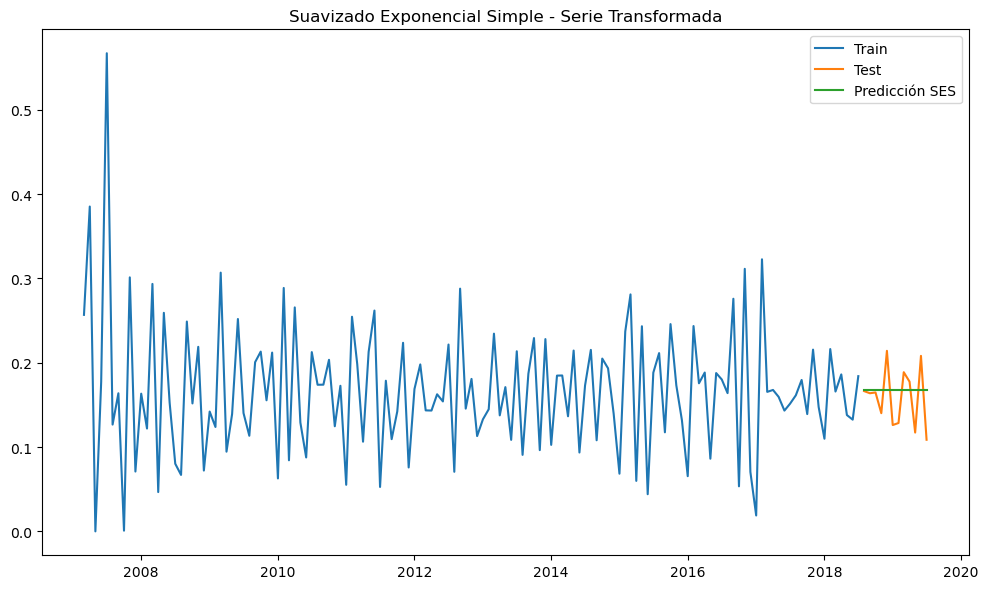

In [11]:
plt.figure(figsize=(10, 6))

plt.plot(train['price'], label="Train")
plt.plot(test['price'], label="Test")
plt.plot(pred, label="Predicción SES")

plt.legend()
plt.title("Suavizado Exponencial Simple - Serie Transformada")
plt.tight_layout()

## Holt Winters

In [12]:
train.head()

,datesold,price
datesold,,
2007-03-01,2007-03-01,0.256799
2007-04-01,2007-04-01,0.385259
2007-05-01,2007-05-01,0.000001
2007-06-01,2007-06-01,0.177559
2007-07-01,2007-07-01,0.567074


In [13]:
modelo_hw = sm.tsa.ExponentialSmoothing(
    train['price'],
    trend=None,
    seasonal='add',
    seasonal_periods=12,
    initialization_method="estimated"
).fit()

c:\Users\danie\anaconda3\envs\mineria_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [14]:
pred = modelo_hw.forecast(steps=s)

In [15]:
mae = mean_absolute_error(test['price'], pred)
rmse = np.sqrt(mean_squared_error(test['price'], pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.04445894745515606
RMSE: 0.052546197285403835


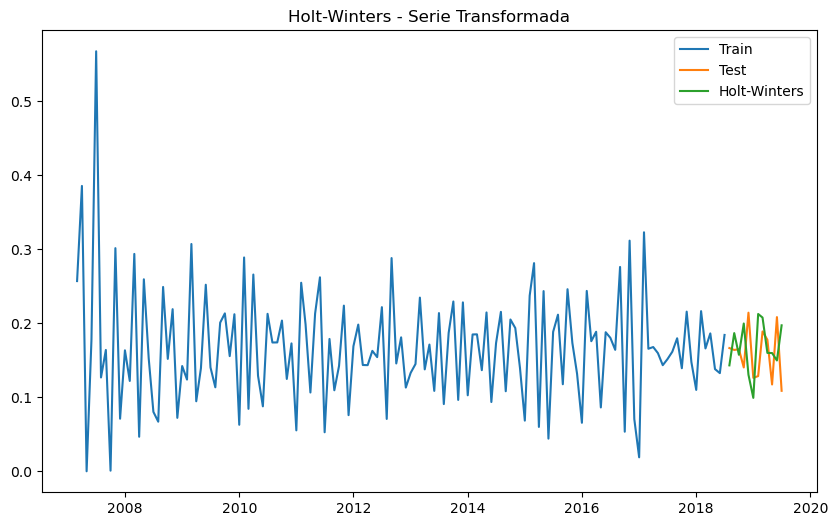

In [16]:
# Gráfico
plt.figure(figsize=(10,6))
plt.plot(train['price'], label="Train")
plt.plot(test['price'], label="Test")
plt.plot(pred, label="Holt-Winters")
plt.legend()
plt.title("Holt-Winters - Serie Transformada")
plt.show()

## Inversión de la logaritmica

In [17]:
def invert_log_diff_shift(pred_transf: pd.Series, params: dict, last_log_train: float):
    """
    Convierte predicciones en escala transformada (log-diff-shift) a escala original.
    last_log_train: último valor de log(serie) del conjunto de entrenamiento (antes de diff).
    """
    # 1) deshacer shift
    pred_log_diff = pred_transf - params["shift_after_diff"]

    # 2) reconstruir log por acumulación
    pred_log = last_log_train + pred_log_diff.cumsum()

    # 3) volver a escala original
    pred = np.exp(pred_log) - params["add_to_make_positive_before_log"]
    return pred

In [18]:
# Cargar parámetros de transformación
with open('../data/processed/transform_params.json', 'r') as f:
    transformation_params = json.load(f)
    


In [19]:
transformation_params

{'eps': 1e-06,
 'add_to_make_positive_before_log': 0.0,
 'shift_after_diff': 0.16148846989111196,
 'last_log_value_before_diff': 13.314359900696479,
 'last_timestamp': '2019-07-01T00:00:00'}

In [20]:
pred_original_scale = invert_log_diff_shift(pred, transformation_params, transformation_params["last_log_value_before_diff"])

In [21]:
pred_original_scale

2018-08-01    594736.068578
2018-09-01    609854.929113
2018-10-01    607264.413044
2018-11-01    630798.894304
2018-12-01    611464.033785
2019-01-01    574496.373518
2019-02-01    604484.759815
2019-03-01    632980.940779
2019-04-01    631932.297926
2019-05-01    630753.113364
2019-06-01    623305.622629
2019-07-01    645883.879906
Freq: MS, dtype: float64

In [22]:
# Cargar la serie original para comparar
serie_original = pd.read_csv('../data/processed/serie_mensual.csv', index_col=0, parse_dates=True)

In [23]:
# pred_original_scale.index = pd.to_datetime(pred_original_scale.index)
train = serie_original.iloc[:-s]
test = serie_original.iloc[-s:]

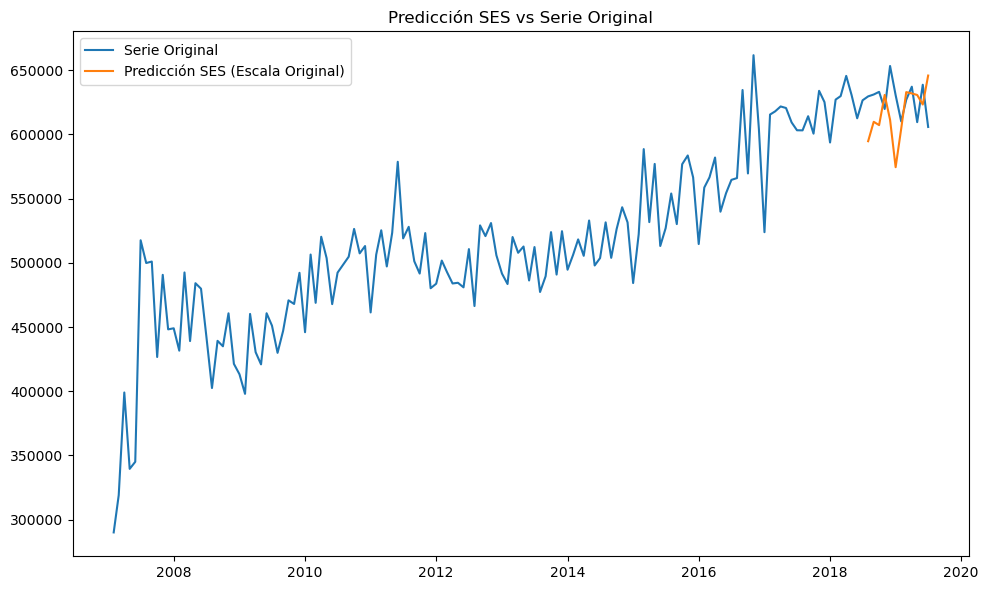

In [24]:
# Graficar la serie original y las predicciones en escala original
plt.figure(figsize=(10, 6))
plt.plot(serie_original, label="Serie Original")
plt.plot(pred_original_scale, label="Predicción SES (Escala Original)")
plt.legend()
plt.title("Predicción SES vs Serie Original")
plt.tight_layout()
plt.show()